# Describing model predictions, using SHAP values and SHAP interactions

[Representing categorical features as one-hot encoded features and kept separate in the SHAP values]

## Plain English summary

When fitting a machine learning model to data to make a prediction, it is now possible, with the use of the SHAP library, to allocate contributions of the prediction onto the feature values. This means that we can now turn these black box methods into transparent models and describe what the model used to obtain it's prediction.

SHAP values are calculated for each feature of each instance for a fitted model. In addition there is the SHAP base value which is the same value for all of the instances. The base value represents the models best guess for any instance without any extra knowledge about the instance (this can also be thought of as the "expected value"). It is possible to obtain the models prediction of an instance by taking the sum of the SHAP base value and each of the SHAP values for the features. This allows the prediction from a model to be transparant, and we can rank the features by their importance in determining the prediction for each instance.

In our previous notebook (03_xgb_combined_shap_key_features.ipynb) we saw that a feature with the same value in multiple instances (such as all of the patients that attend hospital A), the feature (Hospital A) does not necessarily have the same SHAP value in all of those instances. This means that the feature value alone is not a clear indication of the impact it will have on the prediction - this is due to there being feature interactions, such that SHAP values for a feature are influenced by the other feature values. This means that SHAP values are instance dependent (as they are also capturing the interactions between pairs of feature values). The SHAP values therefore are in turn made up of a main effect (what is due to the feature value, the standalone effect) and also the interactions with the other features (a value per feature pairings).

[Note: In this notebook we will refer to the parts of the SHAP value consistently as base value, main effect, and interactions, where the term SHAP feature value refers to the sum of the main effect and interactions].

SHAP values are in the same units as the model output (for XGBoost these are in log odds). 

Here we fit an XGBoost model to the SAMueL dataset, to predict whether a patient recieves thrombolysis from the values of eight features. We calculate the SHAP values (base, main effect and feature interactions) of this fitted model and show the most useful way (that we have found) to present all of these values in order to gain the most insight into how the model is working. At present this is using a grid of SHAP dependency plots.

This notebook is based on the blog https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a

## Model and data
[Using the model trained in notebook 3a, the SHAP values calculated in notebook 3a, and the SHAP interations calculated in notebook 3b].

XGBoost model was trained on all of the data (no test set used). The 8 features in the model are:

* Arrival-to-scan time: Time from arrival at hospital to scan (mins)
* Infarction: Stroke type (1 = infarction, 0 = haemorrhage)
* Stroke severity: Stroke severity (NIHSS) on arrival
* Precise onset time: Onset time type (1 = precise, 0 = best estimate)
* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Use of AF anticoagulents: Use of atrial fibrillation anticoagulant (0 = No, 1 = Yes)
* Onset-to-arrival time: Time from onset of stroke to arrival at hospital (mins)
* Stroke team: Represented as one-hot encoded features

And one target feature:
* Thrombolysis: Did the patient recieve thrombolysis (0 = No, 1 = Yes)

## Aims

* Fit XGBoost model using feature data to predict whether patient gets thrombolysis
* Calculate the SHAP main effect and SHAP interaction values
* Understand the SHAP main effect and SHAP interaction values
* Find the best way to display these values in order to gain the most insight into the relationships that the model is using

## Observations

* SHAP interactions are awesome! 
* SHAP interactions take a lot of thought and consideration when interpreting their meaning. You need to constantly consider the features main effectwhen interpreting the feature interactions. The interactions are not showing absolute relationships - in some cases the feature interactions are adding to the main effect, and in other cases they are undoing (cancelling out) the main effect.
* Viewing SHAP interactions as a grid of SHAP dependency plots clearly shows the overall relationships that the model uses to derive it's predictions for the whole dataset. Never look at a SHAP interaction dependency plot in isolation - always consider how it is interacting with the relationship shown in the main effect.

* It is not possible to display all of the features in the grid of SHAP dependency plots when there are more than, say, 10 features. For our case, we have 139 feautres due to the use of one-hot encoded hospital features. We will explore options to address this in two other notebooks:
1. 12c_xgb_shap_interactions_sum_all_ohe.ipynb : Sum up all the one-hot encoded hospital features and treat as a single feature. By doing so we interpret the SHAP value for the hospital features as "the contribution to the prediction from attending this hospitals AND not the other hospitals".
2. 12d_xgb_shap_interactions_sum_rest_ohe.ipynb: Keeping the attended hospital separate and sum up all the other one-hot encoded hospital features (all of those not attended) and treat as a single feature. By doing so we interpret the two SHAP values as "the contribution to the prediction from the hosptial they attend" and "the contribution to the prediction from not attending the other hospitals".

## Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from xgboost import XGBClassifier

# Import shap for shapley values
import shap # `pip install shap` if neeed

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

from scipy import stats

import os
import pickle

from os.path import exists
import json

/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/kerry/miniconda3/envs/samuel2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set filenames

In [2]:
number_key_features = 8
model_text = f'xgb_{number_key_features}_features'
notebook = '12a'

## Create output folders if needed

In [3]:
path = './saved_models'
if not os.path.exists(path):
    os.makedirs(path)

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [4]:
with open("./output/feature_name_dict.json") as json_file:
    dict_feature_name = json.load(json_file)

## Load data

Data has previously been split into 5 stratified k-fold splits.

For this exercise, we will fit a model using all of the data (rather than train/test splits used to assess accuracy). We will join up all of the test data (by definition, each instance exists only once across all of the 5 test sets)

In [5]:
data_loc = '../data/kfold_5fold/'

In [6]:
# Initialise empty list
test_data_kfold = []

# Read in the names of the selected features for the model
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_key_features]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# For each k-fold split
for i in range(5):
    # Read in test set, restrict to chosen features, rename titles, & store
    test = pd.read_csv(data_loc + 'test_{0}.csv'.format(i))
    test = test[key_features]
    test.rename(columns=dict_feature_name, inplace=True)
    test_data_kfold.append(test)

# Join all the test sets. Set "ignore_index = True" to reset the index in the
#   new dataframe (to run from 0 to n-1), otherwise get duplicate index values
data = pd.concat(test_data_kfold, ignore_index=True)

## Edit data to train XGBoost model

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (thrombolysis or not) `y`.

In [7]:
X = data.drop('Thrombolysis', axis=1)
y = data['Thrombolysis']

Average thromboylsis (this is the expected outcome of each patient, without knowing anything about the patient)

In [8]:
print (f'Average treatment: {round(y.mean(),2)}')

Average treatment: 0.3


## One hot encode hospitals

In [9]:
X_hosp = pd.get_dummies(X['Stroke team'], prefix = 'team')
X = pd.concat([X, X_hosp], axis=1)
X.drop('Stroke team', axis=1, inplace=True)

## Fit XGBoost model

An XGBoost model is trained on the full dataset (rather than train/test splits used to assess accuracy).

Use learning rate 0.5 to regularise the model. As increase learning rate value, this increases regularisation. Using a learning rate of 0.5 gives maximum variation between the hosptials. The default learning rate of 0.1 results in few differences between the hospitals (with eight of the one-hot encoded hospital features were not being used in the model - they each had a 0 SHAP value for all of the instances).

Too low a learning rate results in too ____, too high a learning rate results in too ___.

See https://samuel-book.github.io/samuel_shap_paper_1/xgb_with_feature_selection/91_learning_rate_optimisation.html?highlight=learning%20rate

In [10]:
#model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model = XGBClassifier(random_state=42, learning_rate=0.5)
model.fit(X, y)

[06:06:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Get the predictions for each patient (in terms of the classification, and the probability of being in either class)

In [11]:
y_pred = model.predict(X)
y_proba = model.predict_proba(X)

Calculate the models accuracy

In [12]:
accuracy = np.mean(y == y_pred)
print(f'Model accuracy: {accuracy:0.3f}')

Model accuracy: 0.874


## Get SHAP values

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees.
Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [13]:
%%time

# Set up method to estimate SHAP values for tree models and ensembles of trees

filename = f'./output/03a_{model_text}_shap_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        explainer = pickle.load(filehandler)
else:
    # Set up method to estimate SHAP values for tree models & ensembles of trees
    explainer = shap.TreeExplainer(model)

    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)

# Get SHAP values

filename = f'./output/03a_{model_text}_shap_values_explainer_object.p'
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values = pickle.load(filehandler)
else:
    # Get SHAP values
    shap_values = explainer(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values , filehandler)

CPU times: user 747 ms, sys: 60 ms, total: 807 ms
Wall time: 76.5 ms


The explainer returns the base value which is the same value for all instances [shap_value.base_values], the shap values per feature [shap_value.values]. It also returns the feature dataset values [shap_values.data]. You can (sometimes!) access the feature names from the explainer [explainer.data_feature_names].

Let's take a look at the data held for the first instance:
* .values has the SHAP value for each of the four features.
* .base_values has the best guess value without knowing anything about the instance.
* .data has each of the feature values

In [14]:
shap_values[0]

.values =
array([ 7.04962432e-01,  4.70834434e-01,  9.37760234e-01,  4.88724023e-01,
        3.48922372e-01,  1.90080196e-01, -4.45128560e-01,  6.24495908e-04,
       -5.58784464e-04,  9.94549366e-04, -1.44827543e-04, -4.78777918e-04,
        2.03018426e-03,  1.32616831e-03, -4.62164963e-03, -1.44663296e-04,
       -2.64727464e-03,  1.57258241e-03, -5.47267409e-05,  5.59005048e-03,
       -4.94364649e-03, -2.45308410e-03,  6.91119907e-03,  2.98903068e-03,
       -8.01010709e-03,  1.15073301e-04,  1.01976674e-02,  8.05436866e-06,
       -1.34180160e-03,  7.04234745e-03,  8.45438568e-04, -4.65887540e-04,
       -1.33352196e-02, -6.82451949e-03, -8.29387631e-04, -5.12058055e-03,
       -3.64354905e-03, -1.16270920e-03,  1.54822294e-04, -1.55990687e-03,
        1.06859556e-03,  3.09080351e-03,  1.03797121e-02,  1.74750038e-03,
       -3.29944468e-03,  1.61964737e-03, -7.15182303e-03,  3.09971487e-03,
        4.52662492e-03,  1.35833852e-03,  9.84258251e-04,  2.75278743e-03,
        2.54434

There is one of these for each instance.

In [15]:
shap_values.shape

(88792, 139)

### View SHAP values using beeswarm plot

The beeswarm plot gives a good visual representation of the general SHAP value pattern for the whole dataset. 

Each feature is shown on a separate row. It shows the distribution of the SHAP values for each feature. The colour represents the feature data value, and the shape of the data points represent the distribution of the features SHAP values (with a bulge representing a larger number of points, and a thin row representing fewer points). A SHAP value less than 0 (as seen on the x-axis) contributes to the likelihood that the passenger will not survive, whereas a SHAP value greater than 0 contributes to the likelihood that the patient will recieve thrombolysis.

The actual prediction of whether a patient will recieve thrombolysis is the sum of each of the SHAP feature values and the SHAP base value.

The beeswarm plot shows individual feature results for the most influential features, and repreasents the remaining features in a single row at the bottom. This model has 8 features, of which one feature (stroke team) is represented as one-hot encoded feature yielding 139 features in total. Here we see that seven of the original features (apart from stroke team) are shown as the top 7 influential features, with the one-hot encdoed features following. 

Note: Notebook "03a_xgb_shap_values_focus_on_ohe_hospitals.ipynb" investigates the range of SHAP values per stroke team (looking at each one-hot encoded feature)

The first line on the beeswarm plot represents the feature *infarction*. A red data points represents a high data value (these patient had an infarction), and a blue datapoint represents a low data value (these patients had a haemorrhage). Having a haemorrhage contributes to the likelihood that the patient will not get thrombolysis, whereas having an infarction contributes to the likelihood that they will get thrombolysis. Haemorrhage patients can have a stronger contribution to the outcome (down to -10) than compared to the patients with an infarction (just above zero). There are more datapoints with their value in the 0 to 0.5 SHAP value range than at another equivalent interval.

The second line on the beeswarm represents the feature *arrival-to-scan time*. A red data points represents a high data value (a long time taken for the patient to recieve their scan), a purple datapoint represents a mid point (a mid-duration) and a blue datapoint represents a low data value (a short time for the patient to receive their scan). The longer the duration the stronger the contribution to the likelihood that they will not recieve thrombolysis, the shorter the duration the stronger the contribution to the likelihood that they will receive thrombolysis. There are more datapoints around the 0 to 1 SHAP value range (which are coloured blue, and so represent the short duration) than at another equivalent interval.

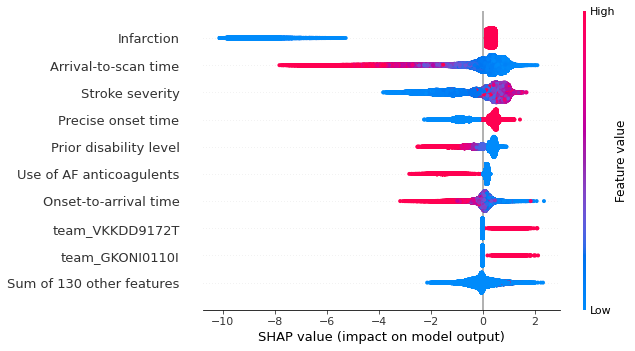

In [16]:
shap.plots.beeswarm(shap_values,show=False)

plt.savefig(f'./output/{notebook}_{model_text}_beeswarm.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)

plt.show()

## Get SHAP interaction values
Use the TreeExplainer to also calculate the SHAP interaction values - a value for each pair-wise feature (the sum of which give the SHAP values for each feature).

In [17]:
%%time

filename = f'./output/03b_{model_text}_shap_interaction_array.p'
file_exists = exists(filename)

if file_exists:
    # Load SHAP interaction
    with open(filename, 'rb') as filehandler:
        shap_interaction = pickle.load(filehandler)
else:
    # Get SHAP interaction values
    shap_interaction = explainer.shap_interaction_values(X)
    
    # Save using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_interaction, filehandler)

CPU times: user 3.98 ms, sys: 2.3 s, total: 2.31 s
Wall time: 2.3 s


SHAP interaction values have a matrix of values (per pair of features) per instance.\
In this case, each of the 88792 instances has a 139 by 139 matrix of SHAP interaction values (with the SHAP main effect on the diagonal positions).

In [18]:
shap_interaction.shape

(88792, 139, 139)

Show SHAP interation matrix (with main effect on the diagonal positions) for the first instance. Notice how the SHAP interation for pairs of features are symmetrical across the diagonal.

In [19]:
shap_interaction[0, 0:4, 0:4]

array([[ 6.9311428e-01,  3.5109535e-02, -5.6171417e-04, -2.3897767e-02],
       [ 3.5109580e-02,  3.4838551e-01,  4.9971551e-02,  2.8483748e-02],
       [-5.6150556e-04,  4.9971461e-02,  8.3505976e-01,  3.2137871e-02],
       [-2.3897827e-02,  2.8483853e-02,  3.2137811e-02,  4.5537671e-01]],
      dtype=float32)

### SHAP interaction matrix: show mean absolute values
Here we see the absolute mean of the SHAP interaction values for all of the instances.\
The values on the diagonal show the main effect for the feature, and the other values show the SHAP interaction for pairs of features (these are symetrical across the diagonal)

In [20]:
mean_abs_interactions = pd.DataFrame(
    np.abs(shap_interaction).mean(axis=(0)),
    index=X.columns, columns=X.columns)

mean_abs_interactions.round(2)

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Use of AF anticoagulents,Onset-to-arrival time,team_AGNOF1041H,team_AKCGO9726K,team_AOBTM3098N,...,team_XKAWN3771U,team_XPABC1435F,team_XQAGA4299B,team_XWUBX0795L,team_YEXCH8391J,team_YPKYH1768F,team_YQMZV4284N,team_ZBVSO0975W,team_ZHCLE1578P,team_ZRRCV7012C
Arrival-to-scan time,1.03,0.10,0.10,0.04,0.04,0.02,0.10,0.0,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
Infarction,0.10,1.57,0.09,0.06,0.04,0.03,0.02,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
Stroke severity,0.10,0.09,0.89,0.05,0.05,0.02,0.05,0.0,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
Precise onset time,0.04,0.06,0.05,0.62,0.03,0.01,0.02,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
Prior disability level,0.04,0.04,0.05,0.03,0.42,0.01,0.02,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
team_YPKYH1768F,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
team_YQMZV4284N,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
team_ZBVSO0975W,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00
team_ZHCLE1578P,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.01,0.00


### The proportion of SHAP that is from the interactions: calculated from the absolute mean
Looking at all of the instances together, what proportion of the SHAP value comes from the SHAP interations

In [21]:
total_shap = mean_abs_interactions.sum().sum()

interaction_shap = (mean_abs_interactions.sum().sum() - 
                    np.diagonal(mean_abs_interactions).sum().sum())

print(f'The proportion of the SHAP values coming from the interactions are: '
      f'{interaction_shap/total_shap:0.3f}')
print(f'The proportion of the SHAP values coming from the main effects are: '
      f'{1 - (interaction_shap/total_shap):0.3f}')

The proportion of the SHAP values coming from the interactions are: 0.363
The proportion of the SHAP values coming from the main effects are: 0.637


### The proportion of SHAP that is from the interactions: calculated per instance from the absolute values
Looking at each instance, what proportion of the SHAP value comes from the SHAP interations. Show the range of proportions (one per instance) as a histogram.

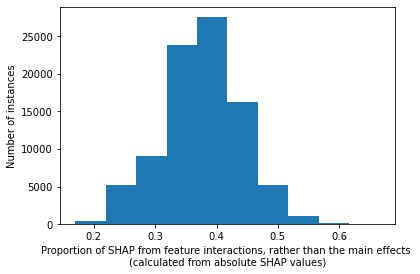

In [22]:
# sum the absolute interaction matrix per instance
abs_total_shap_per_instance = np.abs(shap_interaction).sum(axis=(1,2))

# Initialise list
proportion_interaction = []

# For each instance
for i in range(abs_total_shap_per_instance.shape[0]):
    # sum the absolute feature interactions (off diagonal positions)
    abs_interaction = (abs_total_shap_per_instance[i] - 
                       np.diagonal(np.abs(shap_interaction[i])).sum())
    # calculate the proportion from feature interactions
    proportion_interaction.append(
                abs_interaction / abs_total_shap_per_instance[i])

# plot as histogram
plt.hist(proportion_interaction);
plt.xlabel("Proportion of SHAP from feature interactions, rather than the main "
           "effects \n(calculated from absolute SHAP values)")
plt.ylabel("Number of instances")

plt.savefig(f'./output/{notebook}_{model_text}'
            f'_hist_proportion_of_shap_from_interactions.jpg', dpi=300, 
            bbox_inches='tight', pad_inches=0.2)

plt.show()

### SHAP interaction matrix: represented as histograms 

Show the distribution of all of the instance values for each SHAP interation and SHAP main effect.

Restrict the number of features displayed.

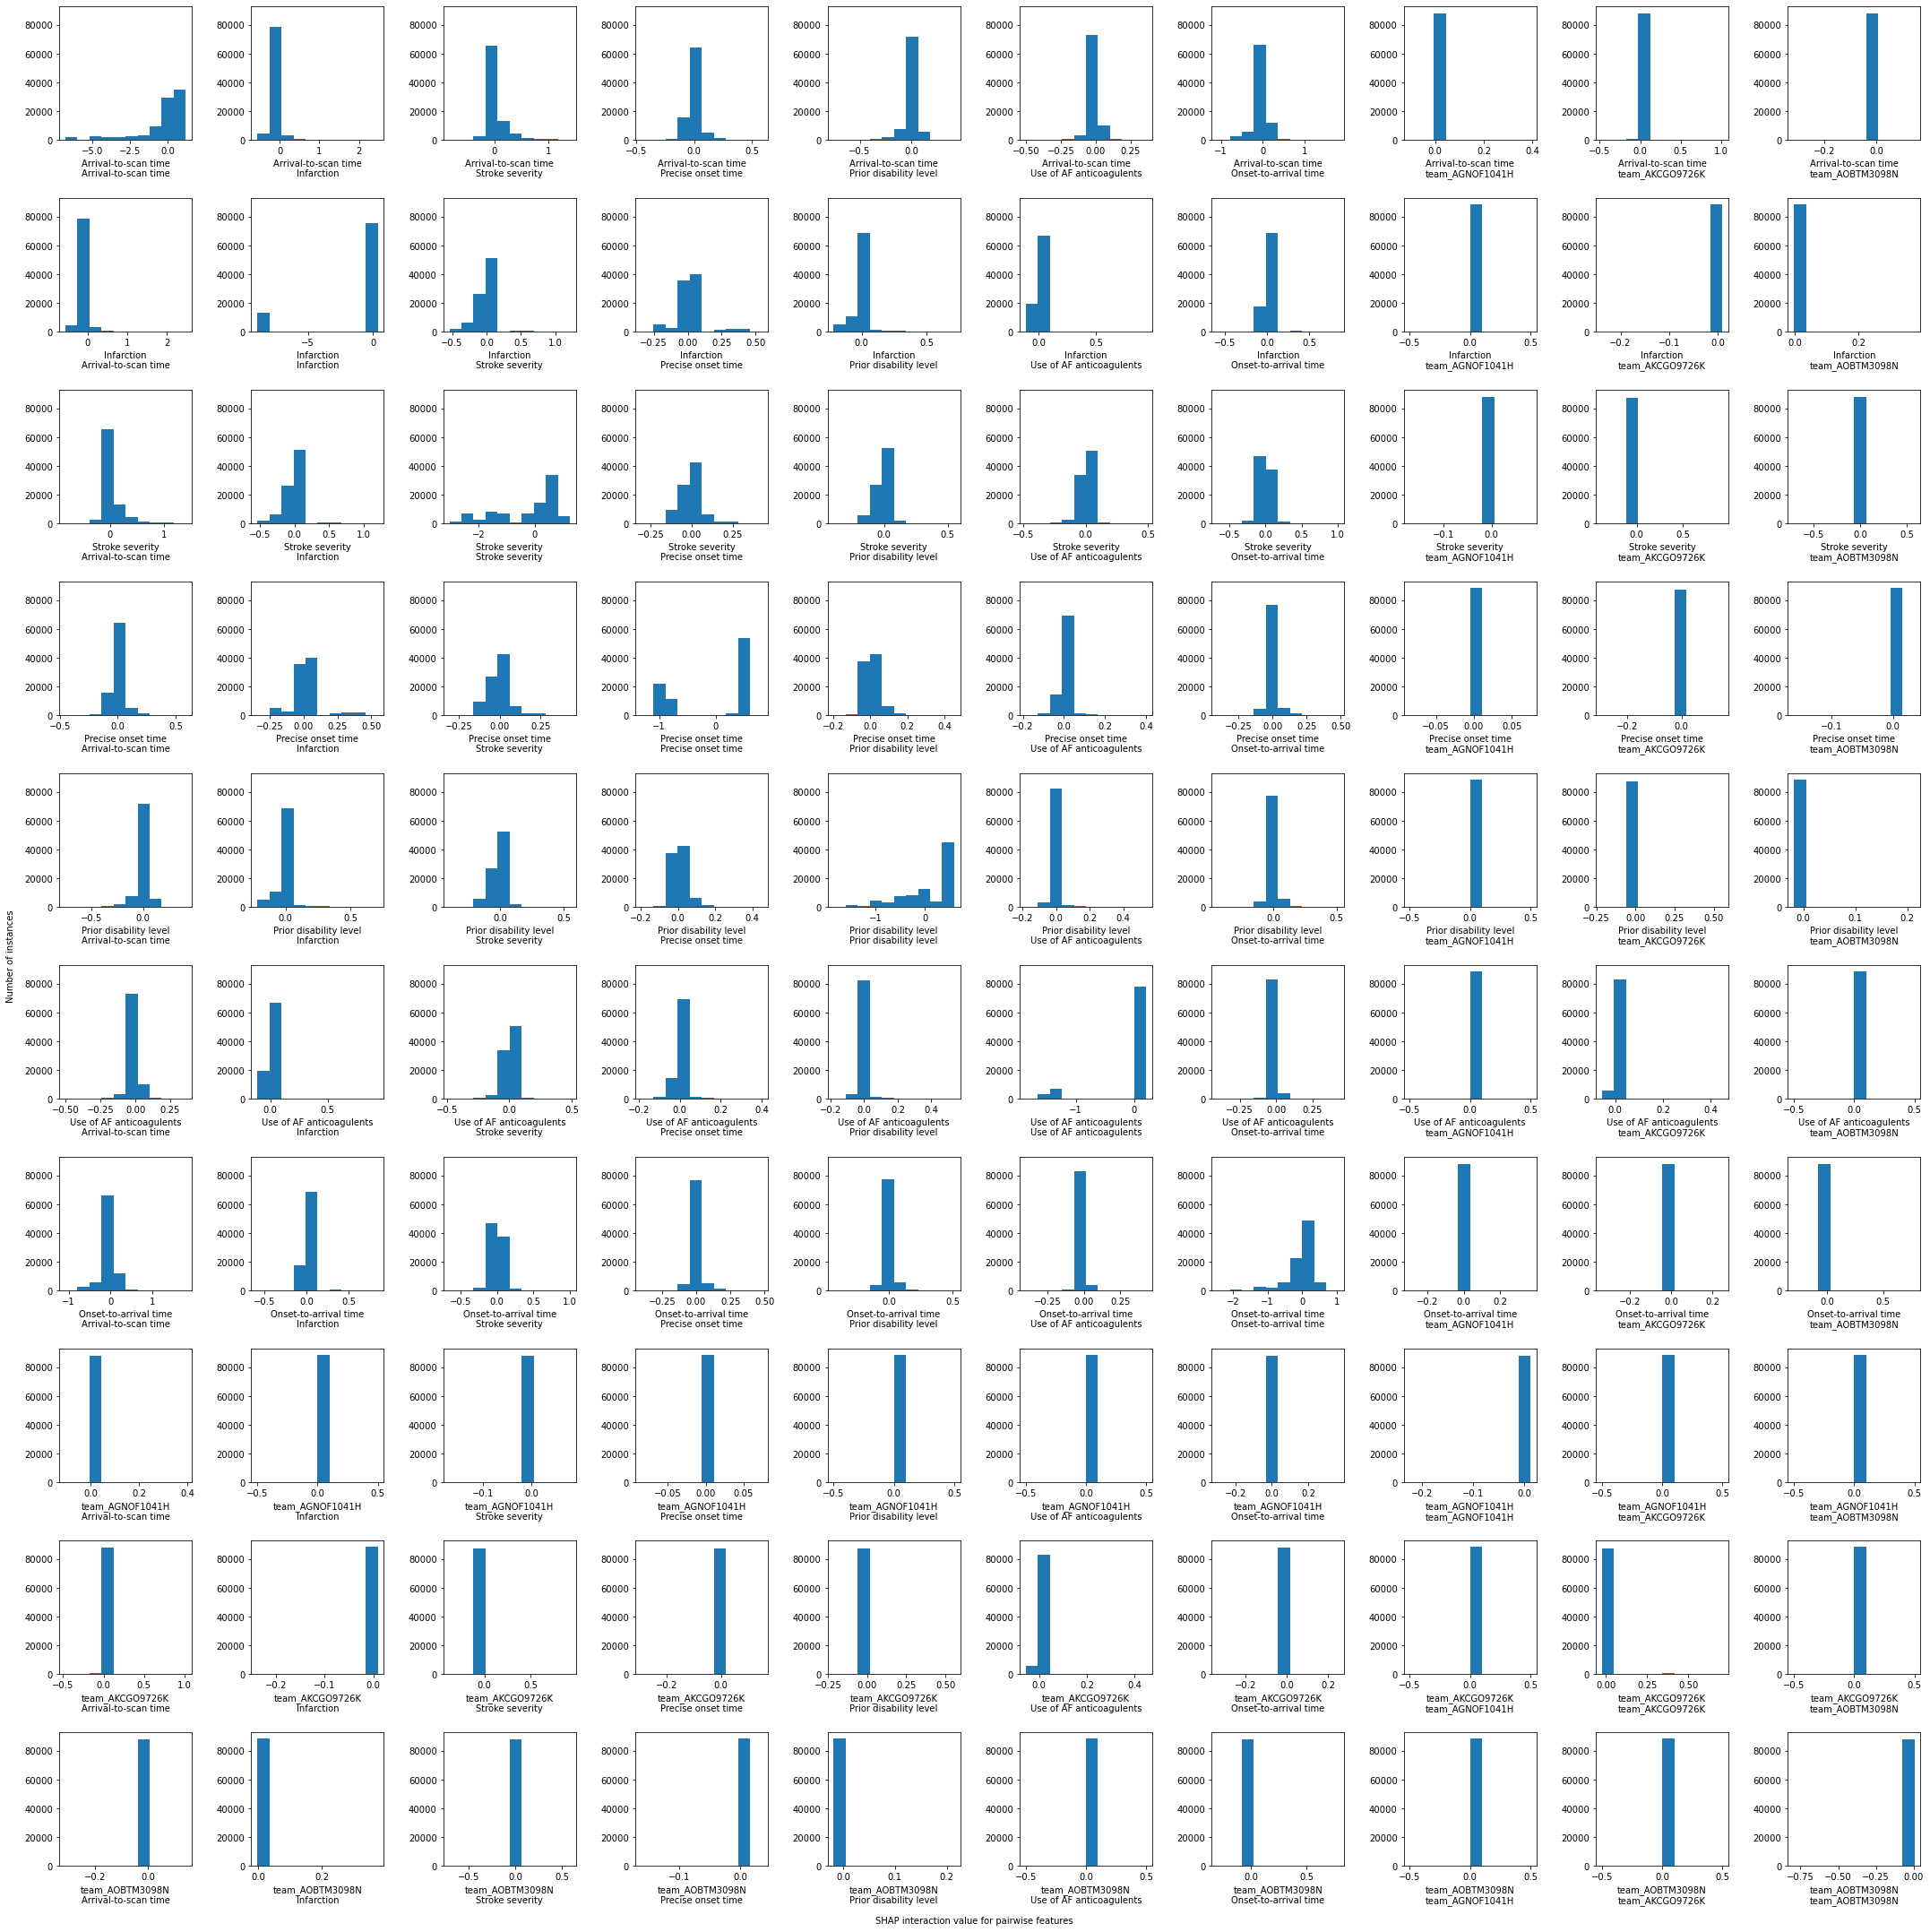

In [23]:
# Define max number of features to display
max_display=10
    
# Get feature names
features = X.columns

# Restrict features to max_display
max_display = min(max_display, len(features))
features = features[0:max_display]

n_features = len(features)

# Find the largest value used for the y axis in all of the histograms in the 
#   subplots (use this to set the max for each subplot)
y_max = -1
fig, axes = plt.subplots(1)
for i in range(n_features):
    for j in range(n_features):    
        axes.hist(shap_interaction[:,i,j])
        ylims = axes.get_ylim()
        # Store if greater than found so far
        y_max = max(y_max, ylims[1])
# Don't display plot
plt.close(fig)

# Setup figure with subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()        

count = 0
for i in range(n_features):
    for j in range(n_features):    
        ax=axes[count]
        ax.hist(shap_interaction[:,i,j])
        ax.set_xlabel(f"{features[i]}\n{features[j]}")
        ax.set_ylim(0, y_max)
        count += 1

fig.text(0.5, 0, 'SHAP interaction value for pairwise features', ha='center')
fig.text(0, 0.5, 'Number of instances' , va='center', rotation='vertical')

fig.set_figheight(30)
fig.set_figwidth(30)
plt.tight_layout(pad=2)

plt.savefig(f'./output/{notebook}_{model_text}_hist_shap_interactions.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

## Show a worked example for the first instance
Start with the feature values, and then show the SHAP values and how they can be represented as main effect and interactions. Also show that by summing them along with the base value gives the model output.

In [24]:
instance = 0
target_category = ["not thrombolysis", "thrombolysis"]
# Show data for first example
print ('Showing a worked example for the first instance')
print ('==============================================')
print ()
print ('------------------')
print ('Feature data values')
print ('------------------')
print (X.iloc[instance])

# Model output
prob_thrombolysis = y_proba[instance][1]
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))
print ()
print ('-------------------')
print ('Model output values')
print ('-------------------')
print (f'1. Model probability [not thrombolysis, thrombolysis]: ' +
       f'{np.round(y_proba[instance],3)}')
##print ('------------')
#print (np.round(y_proba[instance],3))
print (f'\n2. Model log odds survive: {round(logodds_thrombolysis,3)}')
#print ('------------')
#print(round(logodds_survive,3))
cat = np.int(y_pred[instance])
print (f'\n3. Model classification: {cat} ({target_category[cat]})')
##print ('------------')
#print (y_pred[instance])

print ()
print ('-----------------')
print ('SHAP base value (log odds)')
print ('---------------')
print (shap_values.base_values[instance])
print ('\nNote: This is the same value for all of the instances. This is the ' +
       'models best guess without additional knowledge about the instance')
 
#example_shap = pd.DataFrame(shap_values.values[instance],columns=X.columns)
print ()
print ('-----------------')
print ('SHAP values (log odds)')
print ('------------')
# print (example_shap)
for i in range(len(shap_values.values[instance])):
    v = shap_values.values[instance][i]
    print (f'{X.columns.values[i]}: {v:0.3f}')
v = shap_values.values[instance].sum()
print (f'Total = {v:0.3f}')

print ('\nNote: These are patient dependent')
#print ()
#print ('-----------------')
#print ('Sum of SHAP values')
#print ('------------')
#print (shap_values.values[instance].sum())

print (f'\nThe "Model log odds thrombolysis" value ({logodds_thrombolysis:0.3g}, ' +
       f'see above) is calculated by adding up the SHAP base value ' +
       f'({shap_values.base_values[instance]:0.3f}, see above) with ' +
       f'all of the SHAP values for each feature ' +
       f'({shap_values.values[instance].sum():0.3f}, see above)')
print (f'{shap_values.base_values[instance]:0.3f} + ' +
       f'{shap_values.values[instance].sum():0.3f} = ' +
       f'{logodds_thrombolysis:0.3f}')

# SHAP interaction values for first employee
example_interaction = pd.DataFrame(shap_interaction[instance],
                                   index=X.columns,columns=X.columns)
row_total = example_interaction.sum(axis=0)
column_total = example_interaction.sum(axis=1)
total = example_interaction.sum().sum()
example_interaction['Total'] = row_total
example_interaction.loc['Total'] = column_total
example_interaction.loc['Total']['Total'] = total

print ()
print ('-----------------')
print ('SHAP interactions (log odds)')
print ('-----------------')
print ('\n* Each instance has a different SHAP value for the features. This ' +
       'is because the model is also capturing the interaction between pairs ' +
       'of features, and how that contributes to the features SHAP value.')
print ('* Each feature has a SHAP main effect (on the diagonal) and a SHAP ' +
       'interaction effect with each of the other features (off the diagonal)')
print ('* SHAP interaction is split symetrically, eg. age-male is the same ' +
       'as male-age.')
print ('* For each feature, the sum of the SHAP main effect and all of its ' +
       'SHAP interaction values = SHAP value for the feature (shown in ' +
       '"Total", and can be compared to the SHAP values above)')
print ()
print (example_interaction)

print ('------------------')
print ('\nThe model prediction for each instance can be arrived at by ' +
       'starting at the SHAP base value, and adding on the SHAP values from ' +
       'all of the the main effects (one per feature) and from all of the ' +
       'SHAP interactions (two per pair of features).')

Showing a worked example for the first instance

------------------
Feature data values
------------------
Arrival-to-scan time      17.0
Infarction                 1.0
Stroke severity           14.0
Precise onset time         1.0
Prior disability level     0.0
                          ... 
team_YPKYH1768F            0.0
team_YQMZV4284N            0.0
team_ZBVSO0975W            0.0
team_ZHCLE1578P            0.0
team_ZRRCV7012C            0.0
Name: 0, Length: 139, dtype: float64

-------------------
Model output values
-------------------
1. Model probability [not thrombolysis, thrombolysis]: [0.196 0.804]

2. Model log odds survive: 1.409

3. Model classification: 1 (thrombolysis)

-----------------
SHAP base value (log odds)
---------------
-1.1588297

Note: This is the same value for all of the instances. This is the models best guess without additional knowledge about the instance

-----------------
SHAP values (log odds)
------------
Arrival-to-scan time: 0.705
Infarction: 0.471


## Sum of the SHAP value components (base + main effects + interactions) = model prediction 
We've seen a worked through example for one instance that the sum of the SHAP interactions and main effects and base value equals the model output (the log odds of predicted P). 

Here we show that it holds for all of the instances.

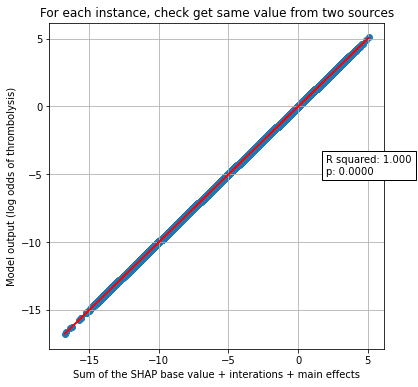

In [25]:
# Model output: probability thrombolysis
prob_thrombolysis = y_proba[:,1]
# Calculate log odds
logodds_thrombolysis = np.log(prob_thrombolysis/(1 -prob_thrombolysis))

# sum each matrix to get a value per instance
total_shap_per_instance = (shap_values.base_values + 
                           shap_interaction.sum(axis=(1,2)))

x = total_shap_per_instance
y = logodds_thrombolysis

# Fit a regression line to the points
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(x, y)
r_square = r_value ** 2
y_pred = intercept + (x * slope)

# Create scatter plot with regression line
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(x, y)
plt.plot (x, y_pred, color = 'red')
text = f'R squared: {r_square:.3f}\np: {p_value:0.4f}'
ax1.text(2, -5, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel("Sum of the SHAP base value + interations + main effects")
ax1.set_ylabel("Model output (log odds of thrombolysis)")
plt.title("For each instance, check get same value from two sources")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}_plot_model_output_vs_sum_of_'
            f'shaps.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

# Histogram of total SHAP

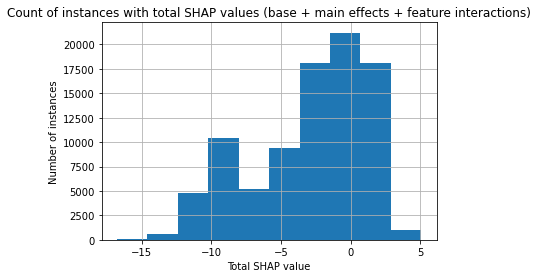

In [26]:
plt.hist(total_shap_per_instance)
plt.xlabel("Total SHAP value")
plt.ylabel("Number of instances")
plt.title("Count of instances with total SHAP values (base + main effects + feature interactions)")
plt.grid()

plt.savefig(f'./output/{notebook}_{model_text}_hist_shap_values.jpg', dpi=300,
            bbox_inches='tight', pad_inches=0.2)

plt.show()

If convert these SHAP values (that are the sum of their interactions, main effects and base value) from log odds to probability, this is the same value as the model prediction. Show that this is the case in two subplots (one showing SHAP values converted from log odds to probability, and the other showing the model output - already as a probability).

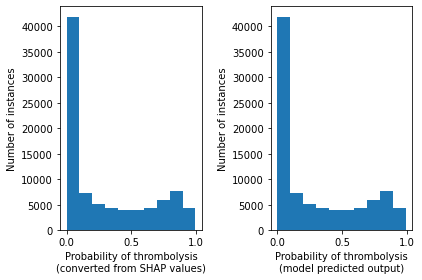

In [27]:
# Convert SHAP values per instance from log odds to probability
probabilities = np.exp(total_shap_per_instance) / (1 + np.exp(total_shap_per_instance))

# Populate lists with data for the two subplots
data = [probabilities,y_proba[:,1]]
xaxes = ["Probability of thrombolysis\n(converted from SHAP values)",
         "Probability of thrombolysis\n(model predicted output)"]

# Create figure
fig, axes = plt.subplots(1,2)
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(data[idx])
    ax.set_xlabel(xaxes[idx])
    ax.set_ylabel("Number of instances")
plt.tight_layout()

plt.savefig(f'./output/{notebook}_{model_text}_hist_probability_two_sources'
            f'.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

For the next section want to know the number of instances with a positive or negative SHAP main effect for the Infarction feature. Calculate here and use the information in the following markdown cell.

In [28]:
feature = "Infarction"
feature_loc = np.where(X.columns==feature)[0][0]
feature_shap_main_effect = shap_interaction[:,feature_loc,feature_loc]

mask = feature_shap_main_effect >= 0
feature_shap_main_effect_positive = feature_shap_main_effect[mask]
print (f'There are {feature_shap_main_effect_positive.shape[0]} instances with '
       f'a positive SHAP main effect for feature {feature}.\nThese are in the '
       f'range {round(feature_shap_main_effect_positive.min(),1)} to '
       f'{round(feature_shap_main_effect_positive.max(),1)}')

print()
mask = feature_shap_main_effect < 0
feature_shap_main_effect_negative = feature_shap_main_effect[mask]
print (f'There are {feature_shap_main_effect_negative.shape[0]} instances with '
       f'a negative SHAP main effect for feature {feature}.\nThese are in the '
       f'range {round(feature_shap_main_effect_negative.max(),1)} to '
       f'{round(feature_shap_main_effect_negative.min(),1)}')

There are 75549 instances with a positive SHAP main effect for feature Infarction.
These are in the range 0.30000001192092896 to 0.4000000059604645

There are 13243 instances with a negative SHAP main effect for feature Infarction.
These are in the range -7.900000095367432 to -8.899999618530273


## How the SHAP main effect (or interaction) varies across the instances: using violin plots

### SHAP main effect of Infarction-Infarction

For this example lets focus on the feature "Infarction". This feature has two possible values: 0 (representing a haemorrhage) and 1 (representing an infarction).

From the histogram in the matrix showing the main effect for the feature Infarction, we can see that there are 75k instances with a main effect of about 0.4, and 13k instances with a main effect of about -8.

From this we can not see which of these instances are which stroke type (infarction of haemmorhage).

Here we will plot this same data using a violin plot, a violin for each type of stroke.

We can see from the violin plot that the main effect (infarction-infarction) is quite different depending on whether the instance is haemorrhage (a negative SHAP main effect value) or infarction (a positive SHAP main effect value).

This means that the feature will contribute a small likelihood of thrombolysis if the instance is infarction, and a strong likelihood of not having thrombolysis if the instance is haemorrhage. This matches the story that we took from the beeswarm plot of the SHAP values, however as we have now extracted just the main effect the violin plot is showing a distinct effect for stroke type. That means that the points on the beeswarm that join up these two distinct groups are from the feature interactions - they "muddy" the relationship (blur the edges, say) between the feature value and SHAP value.

In [29]:
def plot_violin_shap_interaction(X, shap_interaction, main_feature, 
                                 interaction_feature):
    """
    Given the two features (main_feature and interaction_feature), plot the SHAP 
    interations as violin plots. 
    The main_feature will have it's data values displayed on the x axis. 
    The interaction_feature determines the SHAP interaction values that are 
    displayed in the violins.
    If the same feature name is in both (main_feature and interaction_feature)
    then the main effect will be displayed.
    
    X [pandas dataframe]: Feature per column, instance per row
    shap_interaction [3D numpy array]: [instance][feature][feature]
    main_feature [string]: feature name
    interaction_feature [string]: feature name
    
    """
    # Get the unqiue categories for the main feature
    category_list = list(X[main_feature].unique())

    # Setup dictionary and keys (key for each category, each key will hold a 
    #   list of SHAP interaction values for that category)
    shap_interaction_by_category_dict = {}
    for i in category_list:
        shap_interaction_by_category_dict[i]=[]
    
    # Store number of instances and number of categories
    n_instances = X.shape[0]
    n_categories = len(category_list)
    
    # For each instance put its instance interaction value in the corresponding 
    #   list (based on the instances category for the main feature)
    for i in range(n_instances):
        # Identify the instances category for the main feature
        category = X.iloc[i][main_feature]

        # Get the SHAP interaction value for the instance
        instance_interaction = pd.DataFrame(
            shap_interaction[i],index=X.columns,columns=X.columns)
        
        # Get the feature pairing interaction value
        value = instance_interaction.loc[main_feature][interaction_feature]

        # Store value in the dictionary using category as the key
        shap_interaction_by_category_dict[category].append(value)
    
    # Set violin width relative to count of instances
    width = [(len(shap_interaction_by_category_dict[category])/n_instances) 
             for category in category_list]

    # Create list of series to use in violin plot (one per violin)
    shap_per_category = [pd.Series(shap_interaction_by_category_dict[category]) 
                         for category in category_list]
    
    # create violin plot
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()
    ax.violinplot(shap_per_category, showmedians=True, widths=width, )

    # customise the axes
    ax.set_title("")
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=90, fontsize=12)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(
        f'SHAP interaction value for {main_feature}-{interaction_feature}',
        fontsize=12)
    ax.set_xlabel(f'Feature: {main_feature}', fontsize=12)

    plt.subplots_adjust(bottom=0.15, wspace=0.05)

    # Add line at Shap = 0
    ax.plot([0, n_categories + 1], [0,0],c='0.5')
    
    return()

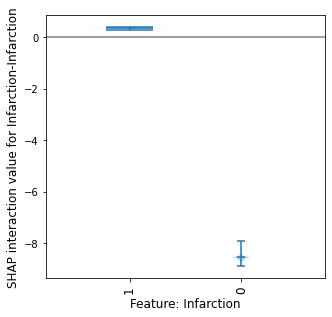

In [30]:
plot_violin_shap_interaction(X, shap_interaction, "Infarction", "Infarction");

### SHAP interaction of Infarction-Precise

We can also see the range of the SHAP interaction values between the features Infarction-Precise (divided by the Infarction categories).

This shows that for an Infarction, the SHAP interaction value between Infarction-Precise ranges from -0.08 to 0.02, and for a haemorrhagic stroke it has a larger range (-0.35 to 0.5). Since this is in addition to the main effect (for which all infarctions had a weak likelihood to recieve thrombolysis), for some infarctions their likelihood for recieving thrombolysis is further increased, whereas for others their likelihood for thrombolysis is reduced.

Remember that we'd need to add on all of the other SHAP interations to get the likelihood of recieving thrombolysis for an infarction.

()

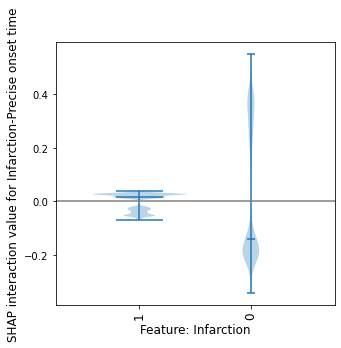

In [31]:
plot_violin_shap_interaction(X, shap_interaction, "Infarction", "Precise onset time")

Violin plots can only display the values for one of the features in a feature-pairing - by it's placement on the x axis. In the violin plot above we can only see the value for the feature male, but not the value for the feature Pclass.

This can be solved by using a SHAP dependency plot - they can show the values for both features and the SHAP interaction value. This is shown in the following section, and we will introduce them using the same data as used in these two violin plots.

## How the SHAP main effect (or interaction) varies across the instances: using dependence plots

### SHAP main effect of Infarction-Infarction

We can see from the violin plot that the main effect (infarction-infarction) is quite different depending on whether the instance is haemorrhagic (a negative SHAP main effect value) or infarction (a positive SHAP main effect value).

This means that the feature will contribute a waek likelihood of recieving thrombolysis if the instance is an infarction, and a strong likelihood of not receiving thrombolysis if the instance is haemorrhagic.

A dependence plot of the same data that's in the violin plot will represent it as individual points, instead of as a distribution. Doing so, it will plot all of the points on two points on the x axis: 0 for haemorrhagic, and 1 for infarction. A lot of information is lost due to this overlap. To see more detail we add some jitter to the x-axis to spread the points out and so we can get a sense of the density of the points in relation to the y value.

Here we see the same information as in the violin plot: the main effect (infarction-infarction) is quite different depending on whether the instance is haemorrhage (a negative SHAP main effect value) or infarction (a positive SHAP main effect value).

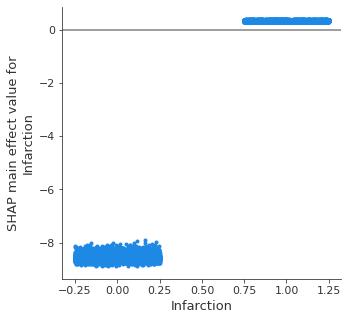

In [32]:
feature_name = "Infarction"

fig = plt.figure()
ax = fig.add_subplot()
shap.dependence_plot(
    (feature_name, feature_name),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[feature_name].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(5)

plt.show()

### SHAP interaction of Infarction-Precise

A hinderence of using a violin plot to show the data for the SHAP interaction of a feature pair is that we can only show one of the feature values (on the x axis). 

When using a dependence plot to show the data for the SHAP interaction of a feature pairing we can display both of the feature values: the point location on the x axis shows the value of one of the features, and the colour of the point shows the value of the other feature.

Note: The SHAP interaction for feature pairings (e.g. infarction-precise) is splt between infarction-precise and precise-infarction. The total SHAP interaction is therefore 2 times the individual interactions. We could multiply the interation by 2 to get the full SHAP interaction. Here we will plot both permutations and acknowledge that it's the sum of the pair (LHS shows columns as Infarction and colour as Precise. RHS shows columns as Precise and colour as Infarction). Each graph contains the exact same data points, and it is possible to match up the identical block of data points across the graphs. For example the red points in the LHS graph represent the precise value 1, and we can see that for these points they have a negative SHAP interaction value for haemorage (x-axis 0) and positive SHAP interaction value for infarction (x-axis 1). We can see these two blocks of red points in the RHS graph, with both blocks now aligned on the x-axis with value 1, and now coloured blue for haemorrhage (with negative SHAP interaction value) or red for infarction (with positive SHAP interaction value).

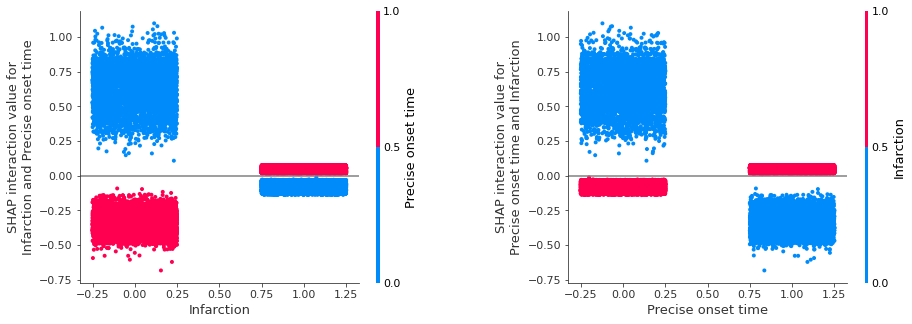

In [33]:
f1 = "Infarction"
f2 = "Precise onset time"

fig = plt.figure()
ax = fig.add_subplot(121)
shap.dependence_plot(
    (f1, f2),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax,
    show=False)

# Add line at Shap = 0
n_violins = X[f1].nunique()
ax.plot([-1, n_violins + 1], [0,0],c='0.5') 

ax1 = fig.add_subplot(122)
shap.dependence_plot(
    (f2, f1),
    shap_interaction, X,
    display_features=X,
    x_jitter=0.5,
    ax=ax1,
    show=False)

# Add line at Shap = 0
n_violins = X[f2].nunique()
ax1.plot([-1, n_violins + 1], [0,0],c='0.5') 

fig.set_figheight(5)
fig.set_figwidth(15)
fig.subplots_adjust(wspace=.4)

plt.savefig(f'./output/{notebook}_{model_text}_dependency_plot_{f1}_'
            f'{f2}.jpg', dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

## Grid of SHAP dependence plots

We will now show all of the SHAP interaction values in a grid of plots: each row and column represents a feature.

The diagonal graphs show the SHAP main effect for each feature. The SHAP interactions between features are off the diagonal, these are split symetrically (eg. infarction-precise == precise-infacrtion). The grid of dependency graphs are a mirror image across the diagonal. Meaning that the same data is shown in position [0,1] as in [1,0] just with the feature being displayed in the column and the feature being displayed by colour is switched over.

Note that to aid interpretability, the *arrival-to-scan time* plots have been truncated at 600 minutes (this feature exceeds 50,000 minutes for some patients).

The SHAP main effect for feature *arrival-to-scan time* is shown in the top left (position [0, 0]). As already discussed, this shows that when the feature value is low, this has a weak contribution to the models prediction that the patient will recieve thrombolysis. And when this feature value is high there is a strong contribution that the patient will not recieve thrombolysis.

The plot in position [1,1] shows the SHAP main effect for infacrtion. This shows that haemorrhages contributes a strong likelihood to not recieve thrombolysis, and an infarction contributes a weak likelihood receiving thrombolysis.

But on top of these main effects we can see the contributon from the interation of these features. This is shown in positions [0, 1] and [1, 0]. The SHAP interaction between *arrival-to-scan time* and *infarction*, and *infarction* and *arrival-to-scan time*.

Graph in grid position [0, 1] (first row, second column) shows the SHAP interaction between *arrival-to-scan time* and *infarction*, the data has been shown with *arrival-to-scan time* on the x-axis, and the colour represents the *infarction* feature (haemorrhage = blue, infarction = red). The y-axis value represents the contribution to the likelihood of this patient receiving thrombolysis due to this combination of values - this is in addition to the main effect that we saw on the diagnoal plots. Never look at a SHAP interaction value in isolation - always consider how it is interacting with the relationship shown in the main effect. For example, on first glance at the SHAP interaction between *arrival-to-scan time* and *infarction* it may appear than having a haemorrhage (blue) contributes positively (and in some cases strongly) to the decision to thrombolyse, whereas an infarction (red) contrigutes a neutral to negative impact on the decision. But when taken in combination with the *arrival-to-scan time* main effect we see that the patients with a haemorrhage are cancelling out the *arrival-to-scan time* main effect, and the patients with an infarction are further contributing to the positive decision for thrombolysis (but only for the short arrival to scan times).

The same can be seen for the main effect for *precise onset time* and the interaction between *precise onset time* and *infarction*. The main effect shows a negative contribution to thrombolysis use if only have a best guess (value 0) and a positive contribution to thrombolysis if have a precise time (value 1). This is to be expected. The interaction between *precise onset time* and *infarction* may, on the surface, appear to be counterintuitive. For a haemorrhage (blue) there appears to be a negative contribution to thrombolysis use if have a precise time (value 1), and a positive contribution to thrombolysis if only have a best guess (value 0). However notice how the range of values would cancel out the main effect. So the result is that due to the main effect of haemorrhage is a strong negative contribution to not have thrombolysis, there is not an effect to be captured for haemorrhagic patients for the other feature values - they are null nd void. Whereas for a patient with an infarction, their interaction between *precise onset time* and *infarction* further contributes to the *precise onset time* main effect.

In summary - SHAP interactions take a lot of thought and consideration when interpreting their meaning. You need to constantly consider the features main effect when interpreting the feature interactions. The interactions are not showing absolute relationships - in some cases the feature interactions are adding to the main effect, and in other cases they are undoing (cancelling out) the main effect.

Resources used to make the grid of dependence plots: https://stackoverflow.com/questions/58510005/python-shap-package-how-to-plot-a-grid-of-dependence-plots \
(for future reference, but not yet used here: https://gist.github.com/eddjberry/3c1818a780d3cb17390744d6e215ba4d)

Restrict the number displayed.
(choosing 10 features includes the 7 continuous features and then the first three one-hot encoded hospital features. The rest are not shown for purposes of visual clarity).

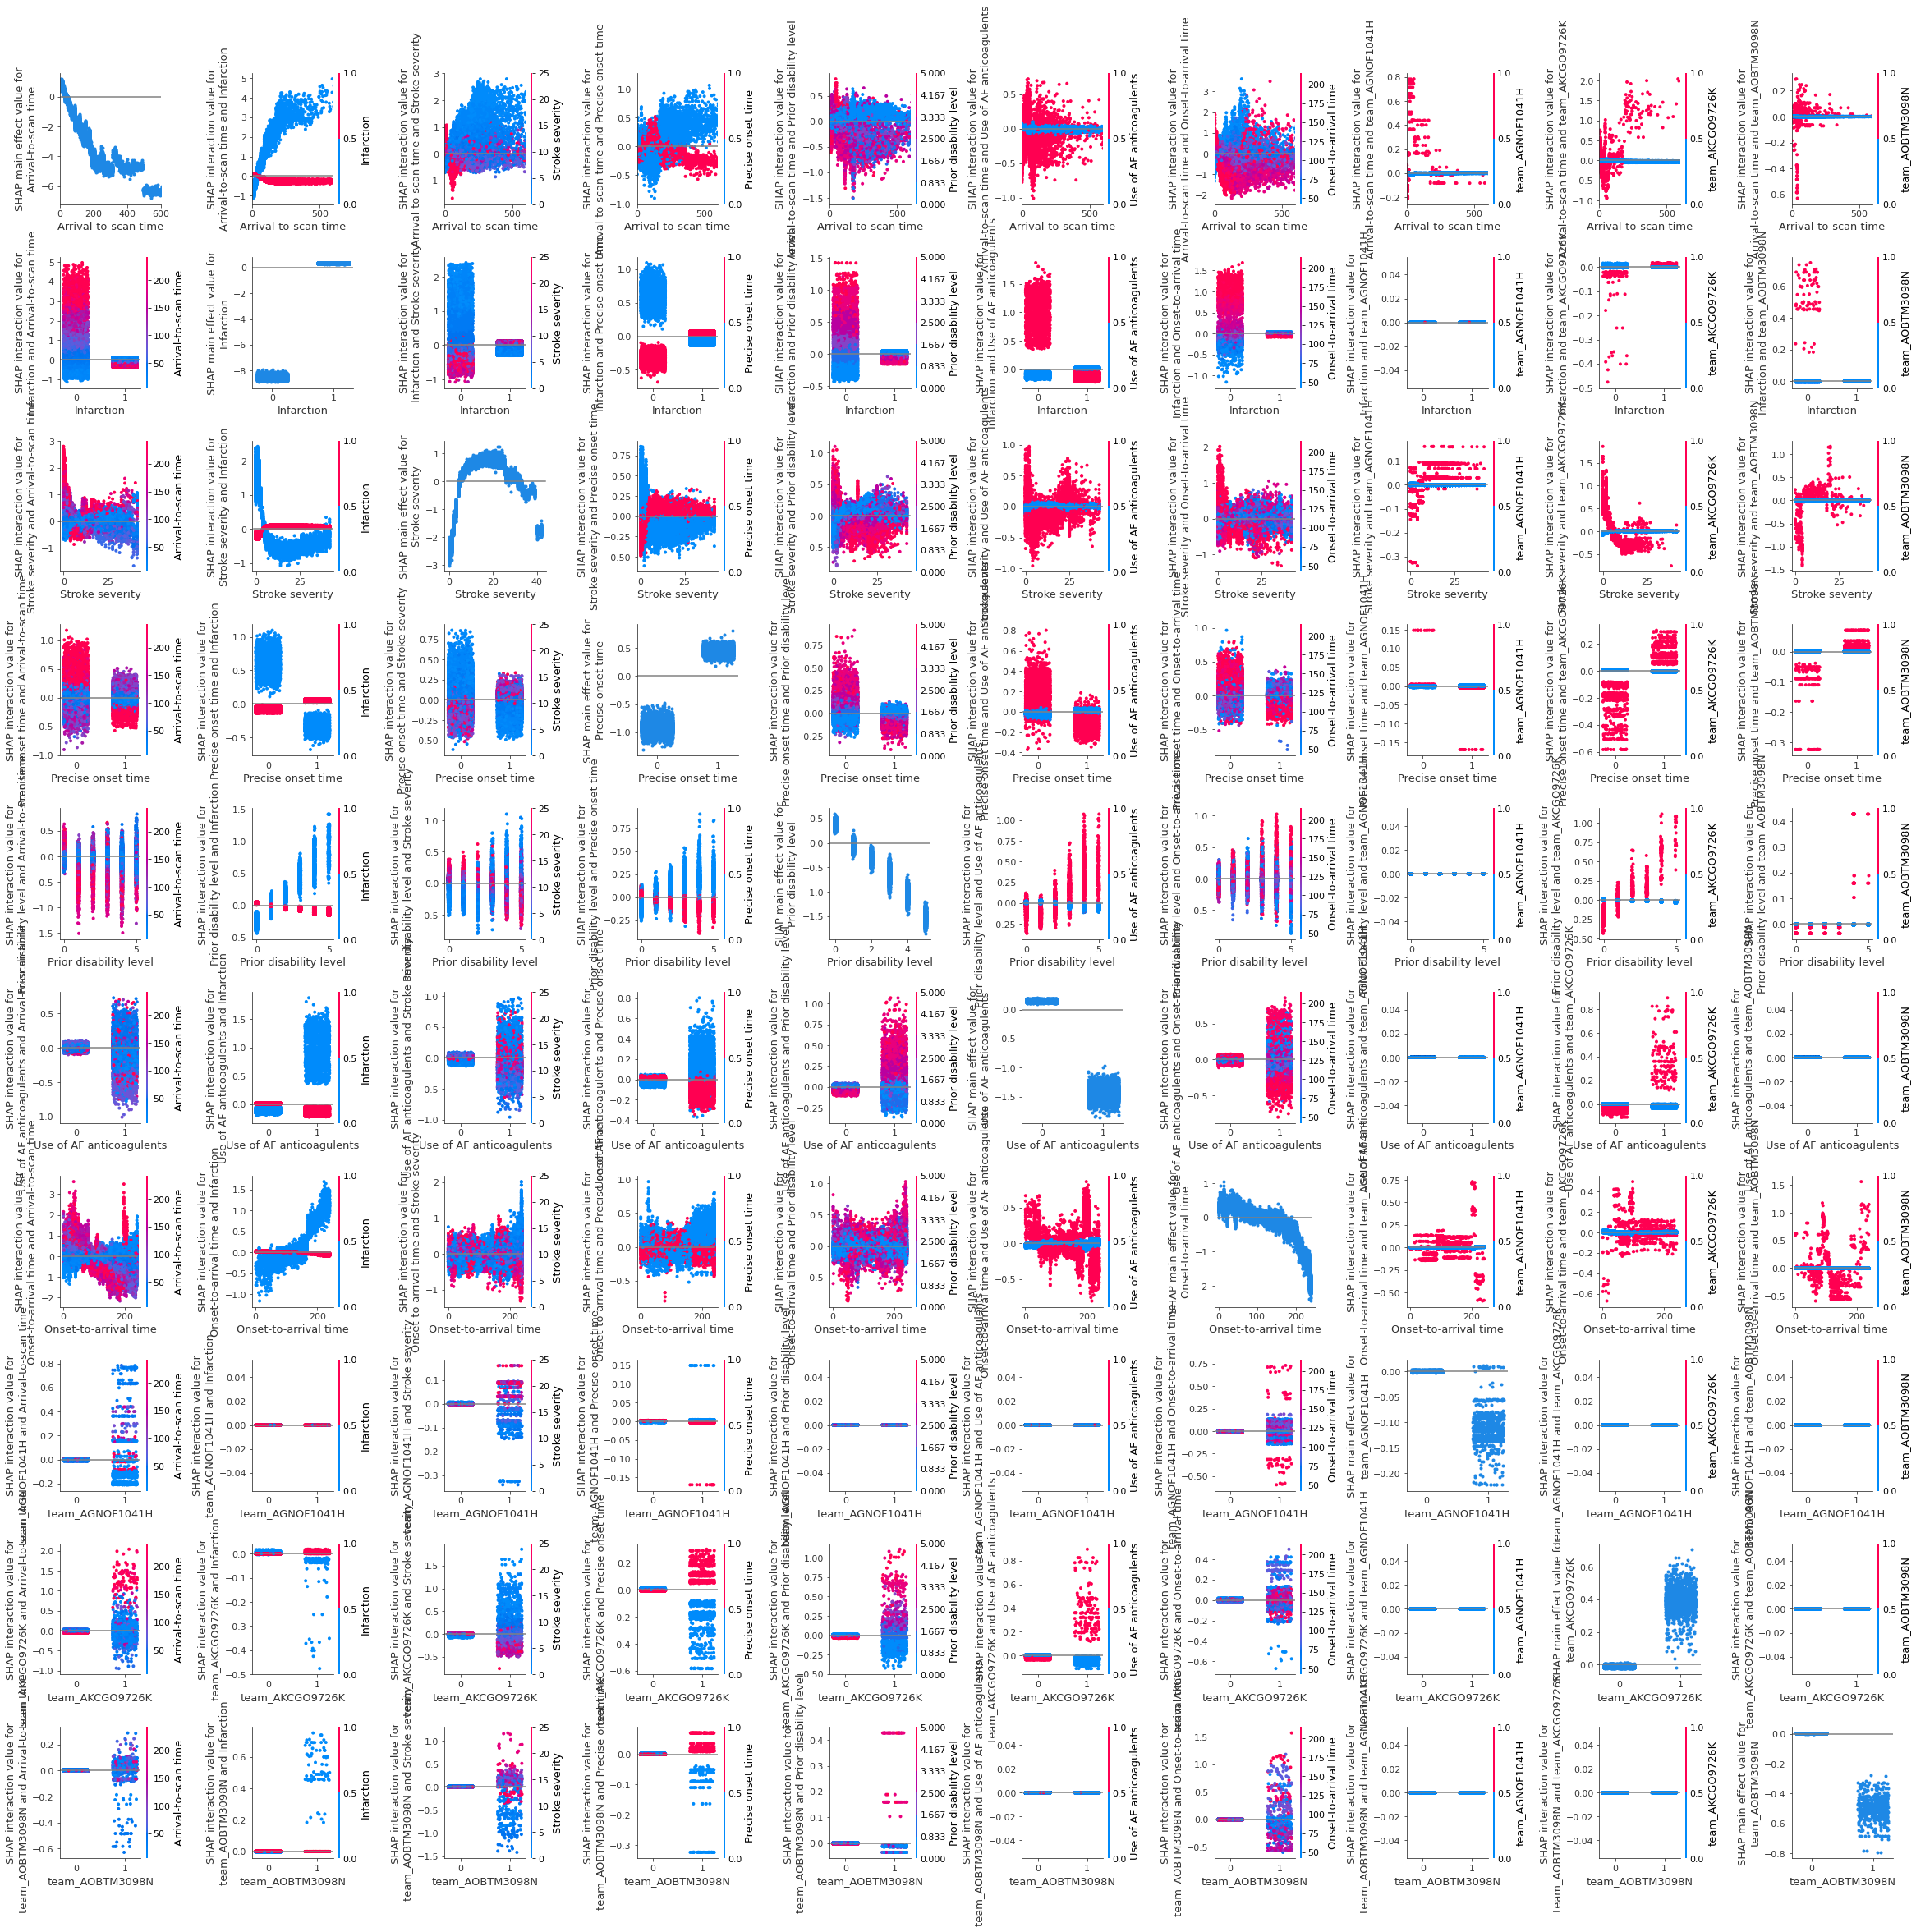

In [36]:
# Define max number of features to display
max_display=10
    
# Get feature names
features = X.columns

# Restrict features to max_display
max_display = min(max_display, len(features))
features = features[0:max_display]

# Set up the matrix of subplots
fig, axes = plt.subplots(
    nrows=len(features), 
    ncols=len(features))
axes = axes.ravel()

# Plot each SHAP independence (and main effect on diagonal)
count = 0
for f1 in features:
    for f2 in features:
        
        # Add more jitter the fewer categories the feature has
        n_categories = X[f1].nunique()
        x_jitter = max(0, 0.7 - (n_categories * 0.1))
            
        # Plot data
        shap.dependence_plot(
            (f1, f2), shap_interaction, X, x_jitter=x_jitter, 
            display_features=X, show=False, ax=axes[count])
        
        # Original values exceed 50k minutes, let's focus on a useful duration
        if f1 == 'Arrival-to-scan time':
            axes[count].set_xlim(0,600)
        
        # Add line at Shap = 0
        n_classes = X[f1].nunique()
        axes[count].plot([-1, n_classes + 1], [0,0],c='0.5')   
        count += 1

# Visual properties of figure
dimension = 4 * n_features
fig.set_figheight(dimension)
fig.set_figwidth(dimension)
#plt.tight_layout(pad=2)
fig.subplots_adjust(hspace=0.4, wspace=0.9)

plt.savefig(f'./output/{notebook}_{model_text}_grid_of_dependency_plots.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()

Each instance is represented in the grid of SHAP depencency plots, and so this shows all of the relationships that the model uses to derive it's predictions for the whole dataset. 

Using the individual instance values you can unpick and understand how each instance gets their classification.

### Please refer to the associated notebook (12aa_xgb_shap_interactions_focus_on_onsettime.ipynb)

Due to the large number of individual features we have (from the 132 one-hot encoded hospital features) it is not possible to display every dependency plot in thie matrix. Therefore we have created notebook 12aa that plots one of the patient features in isolation (for example *precisely known onset time*) and its interaction with all of the one-hot encoded hospital features. It is easy in notebook 12aa to change the feature to look at in isolation.

It takes just the row showing *precisely known onset time* and displays the 132 dependency plots - one for each interaction with an individual hospital.

## Other SHAP plotting options

The SHAP library also offers other plotting options, such as a summary plot based on the beeswarm plot. 

We will show it here for completeness, however we found it to be tricky to interprete, and left gaps in our understanding of the relationships (it left us with further questions). 

It was due to this that we created our grid of dependency plots (as displayed above).

### SHAP interactions summary plot (a grid of beeswarms)

The beeswarm plot at the beginning of this notebook showed the overall SHAP value for the feature. This next plot (a grid of beeswarms) shows the SHAP main effect and SHAP interactions for each feature. Each row and column in this beeswarm matrix represents a feature. The beeswarms on the diagonal represent the SHAP main effect for that feature, and those off the diagonal represent the SHAP interations with the other features.

The graphs are symmetrical around the diagonal, and so the shape of the data in the corresponding graph about the diagonal are the same, however the points are coloured based on the value of the feature represented by the row. For example, the first row this showing the feature *arrival-to-scan time* (so red represents a longer durantion, and blus a short duration). The second row shows the feature *infarction* where blue represents a haemorrage, and red represents an infarction. 

The shape of the data is based on the density of points that have the SHAP interaction value as displayed on the x axis. 

We restrict the number of features displayed (using max_display=30 to overwrite the default of 7 that is used for interaction plots).

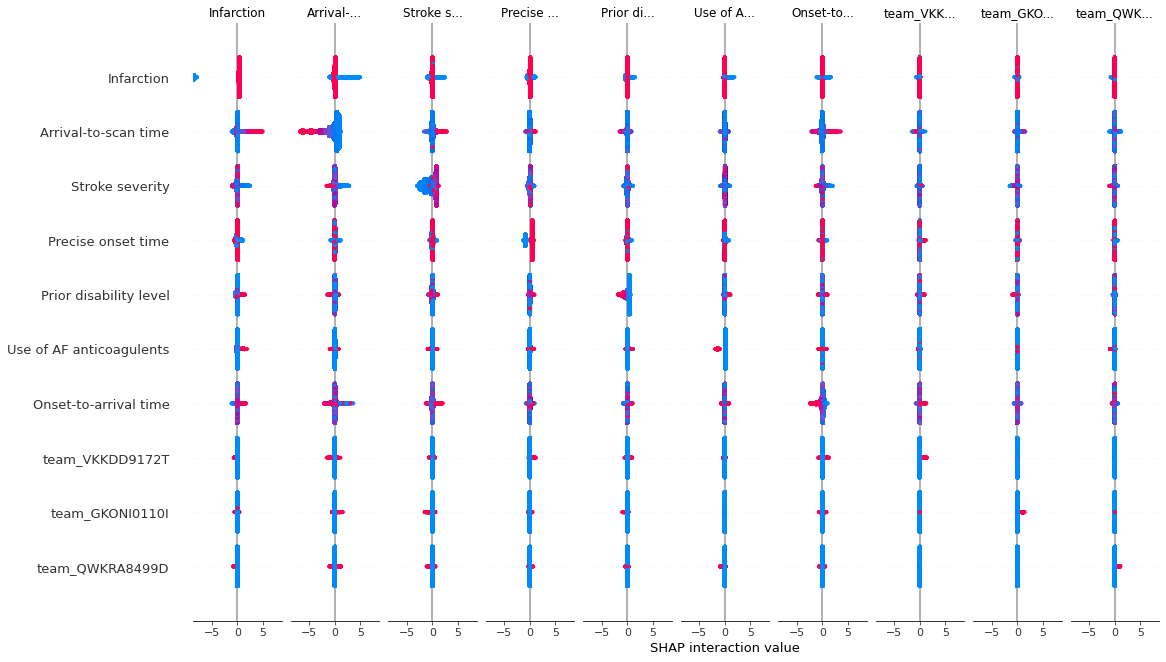

In [35]:
shap.summary_plot(shap_interaction, X, max_display=10, show=False)

plt.savefig(f'./output/{notebook}_{model_text}_grid_of_beeswarm_plots.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)

plt.show()